In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import pymc3 as pm
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
sns.set()

# ガウシアン推定

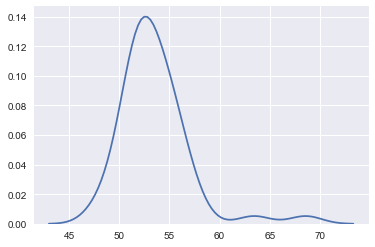

In [11]:
# Gauss分布に従うと想定される実験結果

data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

sns.kdeplot(data)

## 母平均と母分散を推定する

In [12]:
with pm.Model() as model_g:
    mu=pm.Uniform('mu',lower=40,upper=70) # upperとlowerの間にあると仮定
    sigma=pm.HalfNormal('sigma',sd=10) # 半正規分布を仮定
    
    # 事後分布のモデルを構築
    y=pm.Normal('y',mu=mu,sd=sigma,observed=data)
    start=pm.find_MAP()
    trace_g=pm.sample(1100,start=start)

logp = -155.3, ||grad|| = 39.05: 100%|██████████| 9/9 [00:00<00:00, 1166.89it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:02<00:00, 3126.26draws/s]
The acceptance probability does not match the target. It is 0.8804462196731525, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1188c7be0>,
      dtype=object)

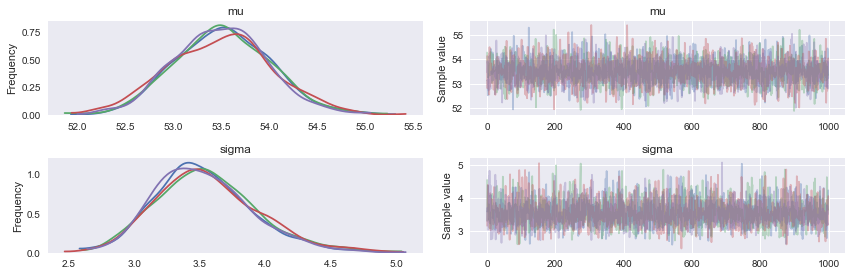

In [13]:
chain_g=trace_g[100:]
pm.traceplot(chain_g)

In [14]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.499751,0.510483,0.007738,52.525363,54.516869,3964.454950,1.000205
sigma,3.542809,0.381279,0.006709,2.857027,4.323814,3698.422631,1.000785


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10dcd14a8>,
      dtype=object)

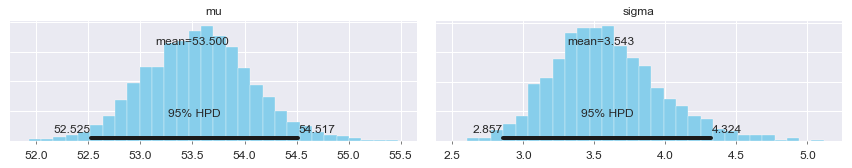

In [15]:
pm.plot_posterior(chain_g)

## 事後分布から、100組の予測値を導出

100%|██████████| 100/100 [00:00<00:00, 1023.64it/s]
/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


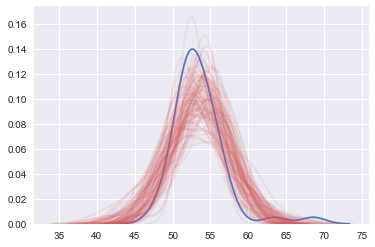

In [36]:
y_pred=pm.sample_ppc(chain_g,100,model_g,size=len(data))
sns.kdeplot(data,c='b')
for i in y_pred['y']:
    sns.kdeplot(i[0],c='r',alpha=0.1)

# student-t

## 分布

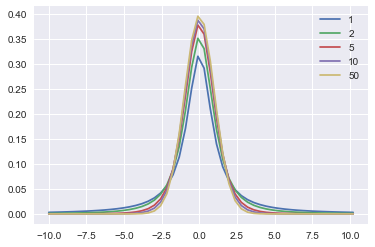

In [17]:
x_value=np.linspace(-10,10.200)

# どれ位ガウス分布に似ているかを表す
norm_values=[1,2,5,10,50]
for norm in norm_values:
    dist=stats.t(norm)
    x_pdf=dist.pdf(x_value)
    plt.plot(x_value,x_pdf,label=norm)
plt.legend()

## 右側の広がりを再現するため、尤度をt分布に置き換える

In [38]:
with pm.Model() as model_t:
    mu=pm.Uniform('mu',40,75)
    sigma=pm.HalfNormal('sigma',sd=10)
    nu=pm.Exponential('nu',1/30)
    y=pm.StudentT('y',mu=mu,sd=sigma,nu=nu,observed=data)
    
    trace_t=pm.sample(1100,njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:02<00:00, 2252.98draws/s]


## 可視化

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c882f98>,
      dtype=object)

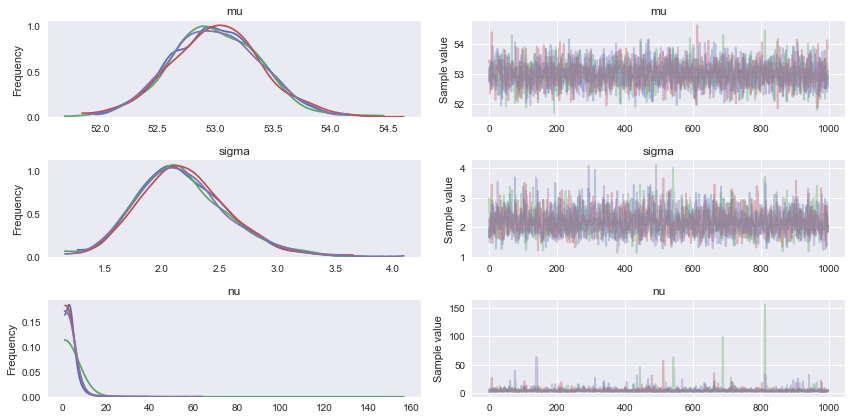

In [39]:
chain_t=trace_t[100:]
pm.traceplot(chain_t)

In [40]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,52.998652,0.395122,0.008013,52.251753,53.816920,2555.929566,0.999744
sigma,2.181371,0.395903,0.008269,1.473794,2.980820,2279.118945,0.999923
nu,4.642525,5.115547,0.122436,1.183914,9.783277,1636.277723,0.999843


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118736a90>,
      dtype=object)

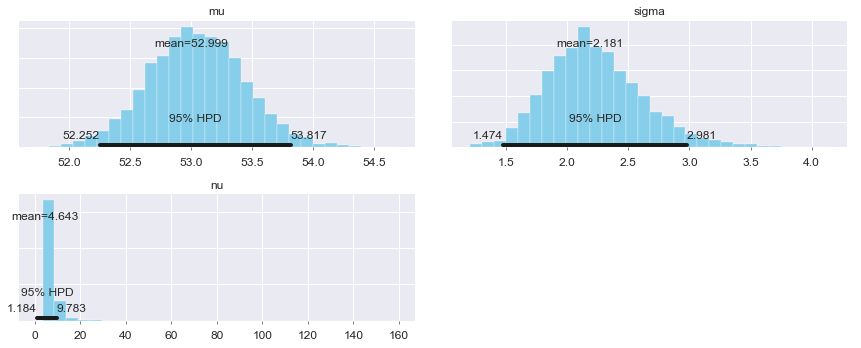

In [41]:
pm.plot_posterior(chain_t)

## 予測分布

100%|██████████| 100/100 [00:00<00:00, 787.64it/s]


(25, 100)

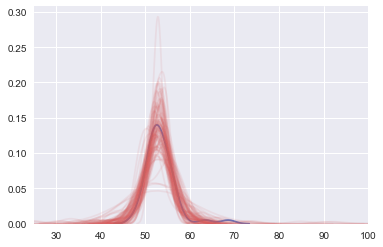

In [43]:
y_pred=pm.sample_ppc(chain_t,100,model_t,size=len(data))
sns.kdeplot(data,color='b')
for i in y_pred['y']:
    sns.kdeplot(i[0],color='r',alpha=0.1)
plt.xlim([25,100])

ロバストなモデルになっている

# グループ間の比較

## 客が払うtipの量を分析する

In [45]:
 tips=sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### 日毎の違いを可視化

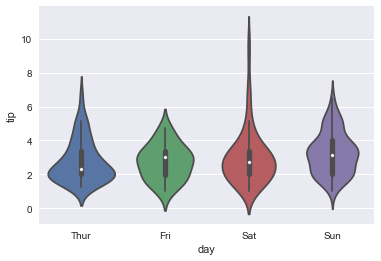

In [47]:
sns.violinplot(x='day',y='tip',data=tips)

## 曜日ごとにモデルを生成

In [95]:
y=tips['tip'].values
x,day=pd.factorize(tips['day'])

In [62]:
with pm.Model() as comparing_groups:
    # dayのカテゴリの数だけ事前分布を作成
    means=pm.Normal('means',mu=0,sd=10,shape=len(set(x)))
    sds=pm.HalfNormal('sds',sd=10,shape=len(set(x)))
    
    # 
    y=pm.Normal('y',mu=means[x],sd=sds[x],observed=y)
    trace_cg=pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:20<00:00, 1081.61draws/s]


In [78]:
# 相関性を排除するため、100個ごとに間引く
chain_cg=trace_cg[100::]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ccf1b38>,
      dtype=object)

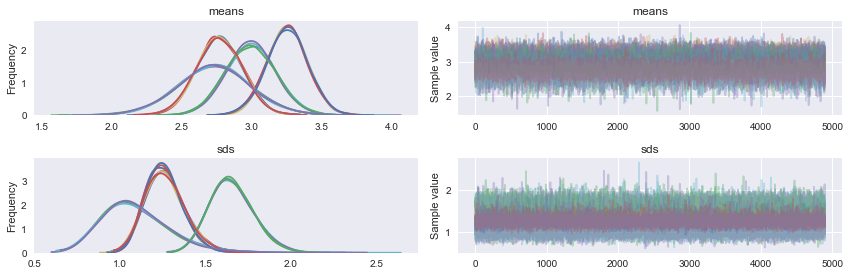

In [79]:
pm.traceplot(chain_cg)

In [80]:
pm.summary(trace_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,3.252561,0.144029,0.000900,2.976517,3.541228,21987.193761,1.000139
means__1,2.992917,0.176610,0.001151,2.645301,3.336847,21364.851436,0.999967
means__2,2.769677,0.162273,0.001044,2.460426,3.094774,19807.682790,1.000127
means__3,2.731914,0.258149,0.001613,2.225563,3.250184,20818.744636,0.999928
sds__0,1.256957,0.105430,0.000810,1.066104,1.471239,21077.931674,0.999941
sds__1,1.653404,0.127821,0.000822,1.414790,1.910880,20629.924466,0.999987
sds__2,1.266262,0.118235,0.000779,1.047457,1.504297,20629.878946,1.000200
sds__3,1.096203,0.199204,0.001422,0.750403,1.490415,17714.544617,0.999913


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a2cf390>,
      dtype=object)

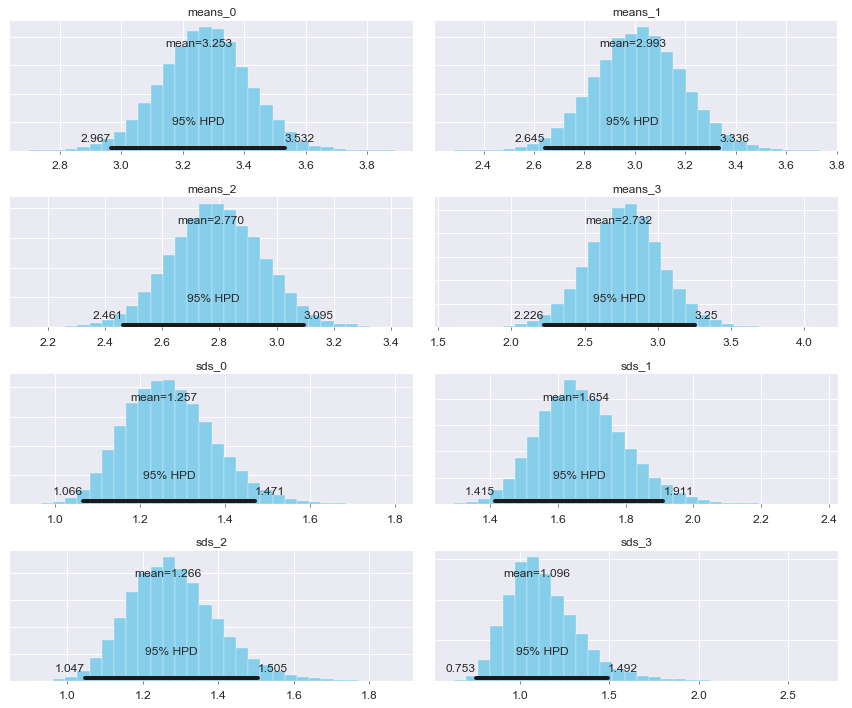

In [82]:
pm.plot_posterior(chain_cg)

'Sun'

## それぞれの曜日間のを比較

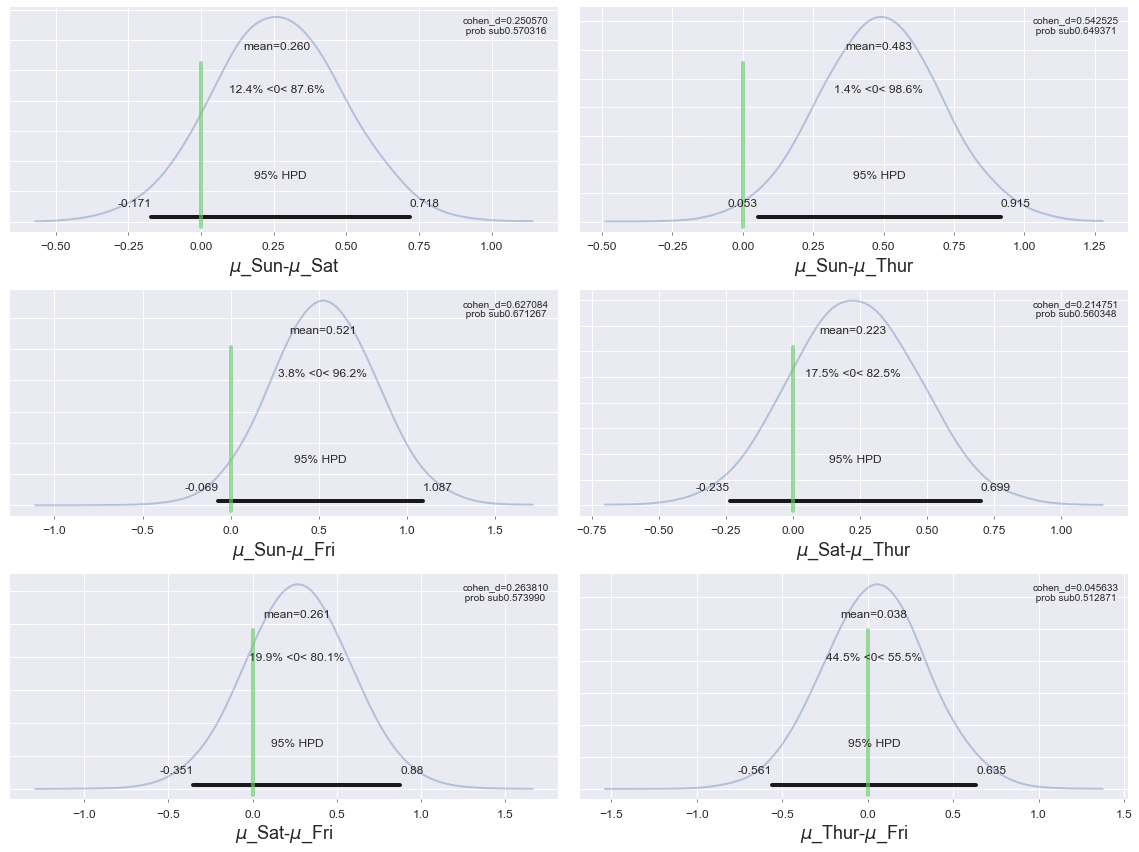

In [106]:
dist=stats.norm()
_,ax=plt.subplots(3,2,figsize=(16,12))


# 組み合わせ
comparisons=[(i,j) for i in range(4) for j in range(i+1,4)]
# 描画する場所
pos=[(k,l) for k in range(3) for l in (0,1)]

for (i,j),(k,l) in zip(comparisons,pos):
    means_diff=chain_cg['means'][:,i]-chain_cg['means'][:,j]
    # コーエンのd
    d_cohen=(means_diff/(np.sqrt(chain_cg['sds'][:,i]**2+chain_cg['sds'][:,j]**2)/2)).mean()
    # 優越率
    ps=dist.cdf(d_cohen/(2**0.5))
    
    pm.plot_posterior(means_diff,ref_val=0,ax=ax[k,l],kde_plot=True,lw=2)
    ax[k,l].plot(0,label=f'cohen_d={d_cohen:2f}\n prob sub{ps:2f}',alpha=0)
    ax[k,l].set_xlabel(f'$\\mu$_{day[i]}-$\\mu$_{day[j]}',fontsize=18)
    ax[k,l].legend(loc='upper right',fontsize=10)
plt.tight_layout()

木曜日と日曜日だけ、有意に差がある

# 階層モデル

## データ作成

In [126]:
# それぞれの場所でのサンプル数
N_samples=[30,30,30]
# そのうち、良好だったサンプル数
G_samples=[18,10,10]

gp_idx=np.repeat(np.arange(len(N_samples)),N_samples)

data=[]
for i in range(0,len(N_samples)):
    data.extend(np.repeat([1,0],[G_samples[i],N_samples[i]-G_samples[i]]))

## 階層モデル作成


In [127]:
with pm.Model() as model_h:
    alpha=pm.HalfCauchy('alpha',beta=10)
    beta=pm.HalfCauchy('beta',beta=10)
    
    theta=pm.Beta('theta',alpha,beta,shape=len(N_samples))
    y=pm.Bernoulli('y',p=theta[gp_idx],observed=data)
    trace_h=pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1309.61draws/s]
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6937037352364027, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7000675935054667, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [128]:
chain_h=trace_h[200:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123bb0828>,
      dtype=object)

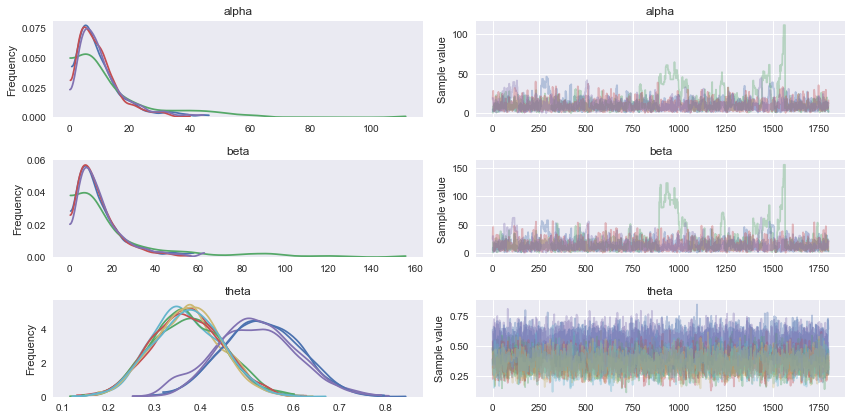

In [129]:
pm.traceplot(chain_h)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123f05128>,
      dtype=object)

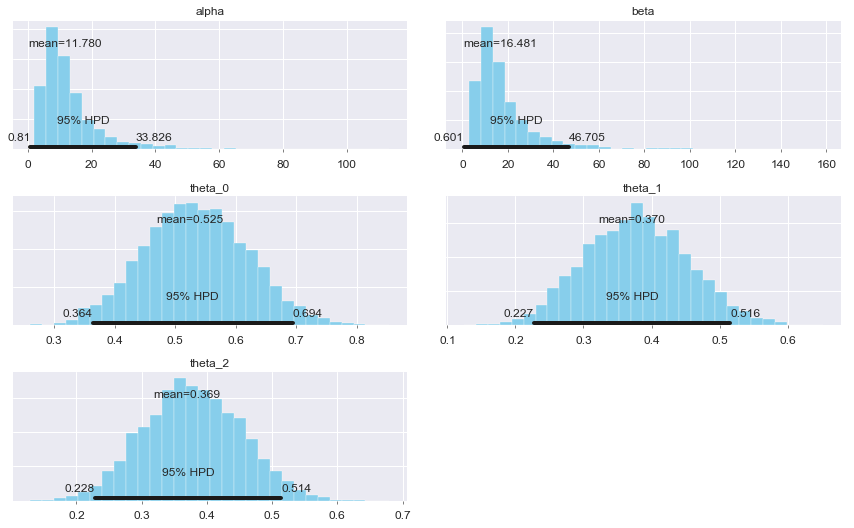

In [130]:
pm.plot_posterior(chain_h)

In [131]:
pm.summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,11.779698,10.543041,0.640664,0.809712,33.825547,122.923833,1.029844
beta,16.481037,16.410128,1.087475,0.601035,46.705272,97.209223,1.037823
theta__0,0.524909,0.085225,0.002694,0.363841,0.694435,639.794113,1.005067
theta__1,0.370149,0.075483,0.001568,0.226755,0.515518,2062.016862,1.000415
theta__2,0.369367,0.074691,0.001293,0.228060,0.513849,3304.494858,1.000132


## 推定したθの事前分布を可視化

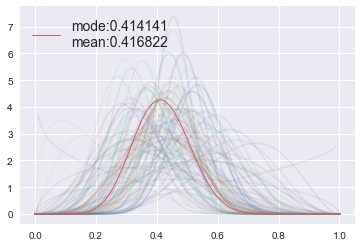

In [145]:
x=np.linspace(0,1,100)

# 100個サンプリング
for i in np.random.randint(0,len(chain_h),size=100):
    pdf=stats.beta(chain_h['alpha'][i],chain_h['beta'][i]).pdf(x)
    plt.plot(x,pdf,alpha=0.1)

# 平均
dist=stats.beta(chain_h['alpha'].mean(),chain_h['beta'].mean())
pdf=dist.pdf(x)
mode=x[np.argmax(pdf)]
mean=dist.moment(1)
plt.plot(x,pdf,label=f'mode:{mode:2f}\nmean:{mean:2f}',c='r',lw=1)
plt.legend(loc='upper left',fontsize=14)

30